
# CGK-DPS

## Data Preparation

In [26]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')
from tabulate import tabulate

In [27]:
df_cgk_dps = pd.read_excel('/content/cgk_dps.xlsx', sheet_name=0, parse_dates=['Tanggal'])

In [28]:
df_cgk_dps.head()

,Tanggal,Harga
0,2022-02-03,499000.0
1,2022-02-04,499000.0
2,2022-02-05,499000.0
3,2022-02-06,566100.0
4,2022-02-07,566100.0


In [29]:
df_cgk_dps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Tanggal  286 non-null    datetime64[ns]
 1   Harga    286 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.6 KB


In [30]:
df_cgk_dps.set_index('Tanggal', inplace=True)
df_cgk_dps.tail(100)

,Harga
Tanggal,
2022-08-08,1181001.0
2022-08-09,1181001.0
2022-08-10,1181001.0
2022-08-11,1181001.0
2022-08-12,1254279.0
...,...
2022-11-11,836000.0
2022-11-12,1400688.0
2022-11-13,1400688.0


## EDA

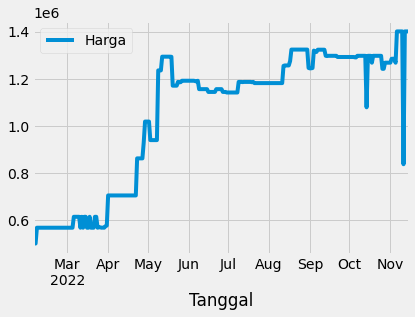

In [ ]:
df_cgk_dps.plot(kind='line')
plt.show()

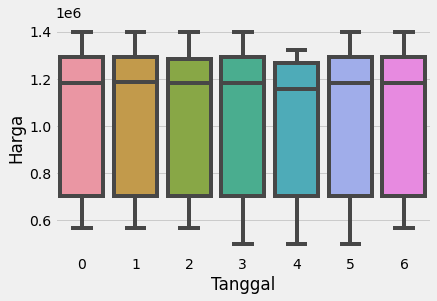

In [ ]:
sns.boxplot(x=df_cgk_dps.index.dayofweek, y=df_cgk_dps['Harga'])
plt.show()

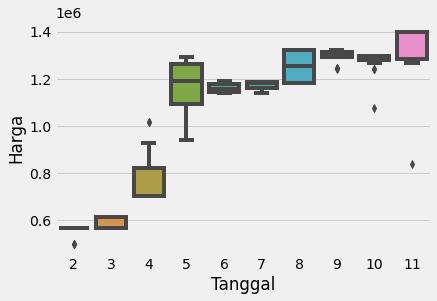

In [ ]:
sns.boxplot(x=df_cgk_dps.index.month, y=df_cgk_dps['Harga'])
plt.show()

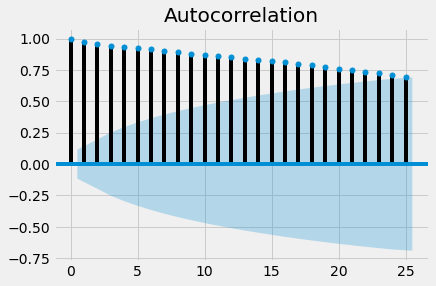

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf

plot_acf(df_cgk_dps['Harga'])
plt.show()

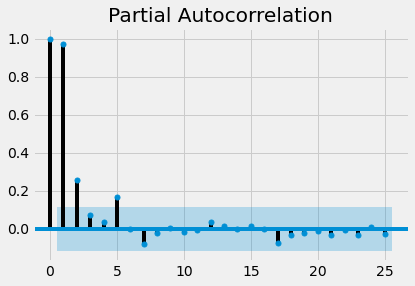

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df_cgk_dps['Harga'], method='ywm')
plt.show()

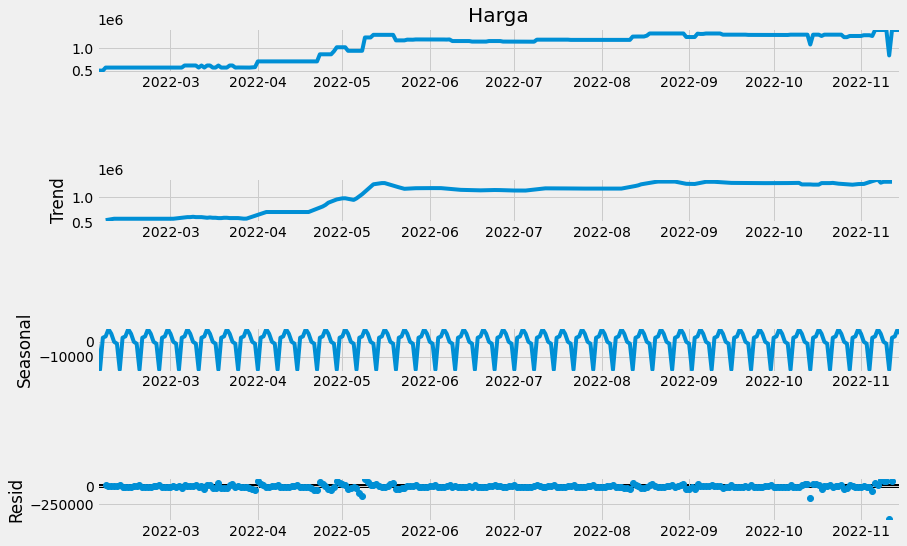

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_cgk_dps['Harga'])
fig = result.plot()
fig.set_size_inches((16, 9))
plt.show()

ide: ambil semua lag yg autocorr nya diluar biru, buatnya bukan lag2=lag2 aja, tapi lag2= lag1,lag2 dst untuk lag lainnya. Ini lebih make sense daripada ambil satu lag aja tiap nyoba.
link buat belajar parameter:
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/?
atau ga cari yg lain gpp, mgt guys maap aku ngaret terus <3

## Tuning Model yeah

In [31]:
#build lags
def create_features(df,n_lag,label=None):
    """
    Creates time series features from datetime index
    """
    df['lag'] = df['Harga'].shift(n_lag)
    
    X = df[['lag']]
    if label:
        y = df[label]
        return X, y
    return X

In [32]:
from datetime import timedelta, datetime
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
df_cgk_dps.tail(100)

,Harga
Tanggal,
2022-08-08,1181001.0
2022-08-09,1181001.0
2022-08-10,1181001.0
2022-08-11,1181001.0
2022-08-12,1254279.0
...,...
2022-11-11,836000.0
2022-11-12,1400688.0
2022-11-13,1400688.0


In [ ]:
#tuning train test split
def cross_validation(data,n_lags,n_splits=10,n_iter=10):
  s= datetime(2022,2,3)  #hari pertama data diambil
  t = datetime(2022,8,8)  #100 hari terakhir
  days_until_depart=100
  rmse_split_mean=[]
  rmse_total_split=[]
  print('=== CROSS VALIDATE LAGS {} START ==='.format(n_lags))
  for i in range(0,days_until_depart,n_splits):
    split_date = t
    s_train = data.loc[s+timedelta(days=n_lags)<data.index].copy()
    train = s_train.loc[s_train.index <= split_date].copy()
    test = data.loc[data.index >= split_date].copy()
    X_train, y_train = create_features(train,n_lags,label='Harga')
    X_test, y_test = create_features(test,n_lags,label='Harga')
    split=100
    tscv = TimeSeriesSplit(n_splits=split)
    rmse=[]
    param=[]
    for j in range(n_iter):
      reg = xgb.XGBRegressor()
      reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=0)
      y_pred=reg.predict(X_test)
      rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    rmse_total_split.append(rmse)
    rmse_split_mean.append(np.mean(rmse))
    t = t - timedelta(days=10)
  rmse_total_split = np.array( rmse_total_split)
  print('Lags {0} RMSE: {1}\n'.format(n_lags, rmse_split_mean))
  return rmse_total_split, rmse_split_mean

In [ ]:
rmse_lags7, rmse_lags7_mean = cross_validation(df_cgk_dps, n_lags=7)
rmse_lags6, rmse_lags6_mean = cross_validation(df_cgk_dps, n_lags=6)
rmse_lags5, rmse_lags5_mean = cross_validation(df_cgk_dps, n_lags=5)
rmse_lags4, rmse_lags4_mean = cross_validation(df_cgk_dps, n_lags=4)
rmse_lags3, rmse_lags3_mean = cross_validation(df_cgk_dps, n_lags=3)
rmse_lags2, rmse_lags2_mean = cross_validation(df_cgk_dps, n_lags=2)
rmse_lags1, rmse_lags1_mean = cross_validation(df_cgk_dps, n_lags=1)

=== CROSS VALIDATE LAGS 7 START ===
[08:10:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:10:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:10:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:10:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:10:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:10:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:10:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:10:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:lin

In [ ]:
print('Lags 5 RMSE Mean:', np.mean(rmse_lags5_mean))
print('Lags 4 RMSE Mean:', np.mean(rmse_lags4_mean))
print('Lags 3 RMSE Mean:', np.mean(rmse_lags3_mean))
print('Lags 2 RMSE Mean:', np.mean(rmse_lags2_mean))
print('Lags 1 RMSE Mean:', np.mean(rmse_lags1_mean))

Lags 5 RMSE Mean: 164952.26660032323
Lags 4 RMSE Mean: 157460.27684246408
Lags 3 RMSE Mean: 144692.42665681354
Lags 2 RMSE Mean: 132440.19708215847
Lags 1 RMSE Mean: 106904.84153563602


In [ ]:
rmse_lags1.mean(axis=1)

array([123822.35534282, 118134.51148624, 113368.99778192, 108402.92057194,
       103105.29768003, 100119.42636451,  97826.6146293 ,  96676.88283382,
       103357.82596461, 104233.58270118])

## Tuning Lagi

Ambil lag= 1 dan test=80, karena mean RMSE nya paling rendah

In [ ]:
df_cgk_dps.tail(80)

,Harga
Tanggal,
2022-08-28,1323499.0
2022-08-29,1323499.0
2022-08-30,1323499.0
2022-08-31,1245328.0
2022-09-01,1243573.0
...,...
2022-11-11,836000.0
2022-11-12,1400688.0
2022-11-13,1400688.0


In [33]:
s= datetime(2022,2,3)
t=datetime(2022,8,28)
split_date = t
s_train = df_cgk_dps.loc[s+timedelta(days=1)<df_cgk_dps.index].copy()
train = s_train.loc[s_train.index <= split_date].copy()
test = df_cgk_dps.loc[df_cgk_dps.index >= split_date].copy()
X_train, y_train = create_features(train,1,label='Harga')
X_test, y_test = create_features(test,1,label='Harga')

In [ ]:
y_test

Tanggal
2022-08-28    1323499.0
2022-08-29    1323499.0
2022-08-30    1323499.0
2022-08-31    1245328.0
2022-09-01    1243573.0
                ...    
2022-11-11     836000.0
2022-11-12    1400688.0
2022-11-13    1400688.0
2022-11-14    1400688.0
2022-11-15    1400688.0
Name: Harga, Length: 80, dtype: float64

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=100)
rmse=[]
param_tun=[]
for i in range(10):
  params = {'max_depth': [3, 5, 6, 7, 8, 9, 10],
            'min_child_weight':[6, 5, 4, 3, 2],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 0.75, 1.0),            #Typical values: 0.5-1
           'colsample_bytree': np.arange(0.5, 0.75, 1.0),     #Typical values: 0.5-1
           'colsample_bylevel': np.arange(0.5, 0.75, 1.0),    #Typical values: 0.5-1
           'eta':[0.01, 0.015, 0.05, 0.075, 0.1, 0.15, 0.2],           #Typical final values to be used: 0.01-0.2  
           'lambda':[0.00001, 0.0001, 0.001, 0.01, 0.05],              #L2 regularization, (0,0.1)
           'gamma':[0.01, 0.015, 0.05, 0.075, 0.1, 0.15, 0.2],        #Typical final values to be used: 0.01-0.2 
           'alpha':[0.00001, 0.0001, 0.001, 0.01, 0.05],              #L1 regularization, (0,0.1)
           'n_estimators': [100, 500, 1000]}
  xgbr = xgb.XGBRegressor(seed = 20)
  clf = RandomizedSearchCV(estimator=xgbr,
                         param_distributions=params,
                         scoring='neg_mean_squared_error',
                         n_iter=100,cv=tscv,
                         verbose=1)
  clf.fit(X_train,y_train)
  rmse.append((-clf.best_score_)**(1/2.0))
  param_tun.append(clf.best_params_)

Streaming output truncated to the last 5000 lines.
[09:38:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:38:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:38:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:38:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:38:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:38:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:38:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:38:26] WARNING: /workspace/src/objective/regression_obj.

In [ ]:
print('Nilai RMSE Maksimal=',np.max(rmse))
print('Nilai RMSE Minimal=',np.min(rmse))
print('Nilai Rata-rata RMSE=',np.mean(rmse))
print('Nilai Median RMSE=',np.median(rmse))
print('Parameter untuk RMSE Minimal:',param_tun[rmse.index(np.min(rmse))])

Nilai RMSE Maksimal= 43427.869622723396
Nilai RMSE Minimal= 43258.06751105369
Nilai Rata-rata RMSE= 43304.49918748971
Nilai Median RMSE= 43279.763615235395
Parameter untuk RMSE Minimal: {'subsample': 0.5, 'n_estimators': 500, 'min_child_weight': 2, 'max_depth': 3, 'learning_rate': 0.3, 'lambda': 0.01, 'gamma': 0.1, 'eta': 0.015, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'alpha': 0.0001}


## Prediction

'subsample': 0.5, 'n_estimators': 500, 'min_child_weight': 2, 'max_depth': 3, 'learning_rate': 0.3, 'lambda': 0.01, 'gamma': 0.1, 'eta': 0.015, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'alpha': 0.0001

In [34]:
reg = xgb.XGBRegressor(subsample= 0.5,n_estimators=500,min_child_weight=2,max_depth=3, gamma=0.1,
                       learning_rate=0.3,colsample_bytree= 0.5,eta=0.015,
                       colsample_bylevel= 0.5,reg_alpha=0.0001, 
                       reg_lambda=0.01)

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

[08:28:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bylevel=0.5, colsample_bytree=0.5, eta=0.015, gamma=0.1,
             learning_rate=0.3, min_child_weight=2, n_estimators=500,
             reg_alpha=0.0001, reg_lambda=0.01, subsample=0.5)

In [35]:
test['Test_Prediksi'] = reg.predict(X_test)
all = pd.concat([test, train], sort=False)

In [36]:
y_test

Tanggal
2022-08-28    1323499.0
2022-08-29    1323499.0
2022-08-30    1323499.0
2022-08-31    1245328.0
2022-09-01    1243573.0
                ...    
2022-11-11     836000.0
2022-11-12    1400688.0
2022-11-13    1400688.0
2022-11-14    1400688.0
2022-11-15    1400688.0
Name: Harga, Length: 80, dtype: float64

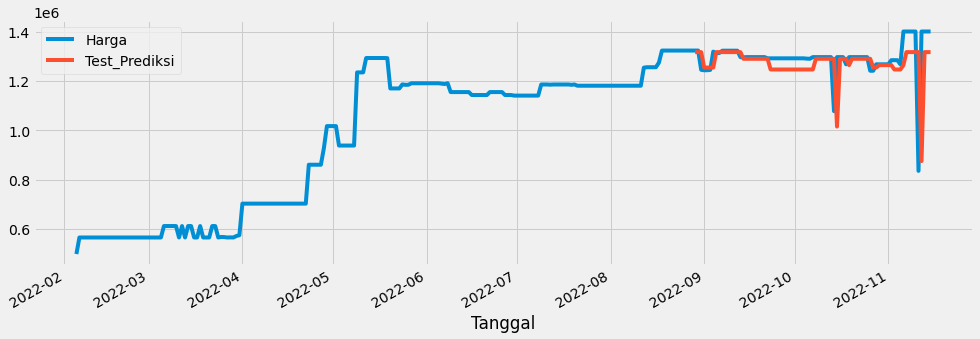

In [37]:
_ = all[['Harga','Test_Prediksi']].plot(figsize=(15, 5))

In [38]:
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

In [39]:
X_test

,lag
Tanggal,
2022-08-28,NaN
2022-08-29,1323499.0
2022-08-30,1323499.0
2022-08-31,1323499.0
2022-09-01,1245328.0
...,...
2022-11-11,1400688.0
2022-11-12,836000.0
2022-11-13,1400688.0


In [40]:
df_cgk_dps2 = df_cgk_dps.copy()
df_cgk_dps2['Prediksi'] = 0

df_cgk_dps2.tail(100)

,Harga,Prediksi
Tanggal,,
2022-08-08,1181001.0,0
2022-08-09,1181001.0,0
2022-08-10,1181001.0,0
2022-08-11,1181001.0,0
2022-08-12,1254279.0,0
...,...,...
2022-11-11,836000.0,0
2022-11-12,1400688.0,0
2022-11-13,1400688.0,0


In [41]:
y_test_pred.shape

(80,)

In [42]:
y_train_pred.shape

(205,)

In [43]:
df_cgk_dps2.iloc[:1, 1] = np.nan
df_cgk_dps2.iloc[1:-80, 1] = y_train_pred
df_cgk_dps2

,Harga,Prediksi
Tanggal,,
2022-02-03,499000.0,NaN
2022-02-04,499000.0,591271.37500
2022-02-05,499000.0,481845.90625
2022-02-06,566100.0,575750.31250
2022-02-07,566100.0,575750.31250
...,...,...
2022-11-11,836000.0,0.00000
2022-11-12,1400688.0,0.00000
2022-11-13,1400688.0,0.00000


In [44]:
y_test_pred.shape

(80,)

In [45]:
df_cgk_dps2.iloc[-80:, 1] = y_test_pred
df_cgk_dps2

,Harga,Prediksi
Tanggal,,
2022-02-03,499000.0,NaN
2022-02-04,499000.0,5.912714e+05
2022-02-05,499000.0,4.818459e+05
2022-02-06,566100.0,5.757503e+05
2022-02-07,566100.0,5.757503e+05
...,...,...
2022-11-11,836000.0,1.317170e+06
2022-11-12,1400688.0,8.757352e+05
2022-11-13,1400688.0,1.317170e+06


In [46]:
print((df_cgk_dps2['Prediksi'].where(df_cgk_dps2['Prediksi']==0)).tail(83))

Tanggal
2022-08-25   NaN
2022-08-26   NaN
2022-08-27   NaN
2022-08-28   NaN
2022-08-29   NaN
              ..
2022-11-11   NaN
2022-11-12   NaN
2022-11-13   NaN
2022-11-14   NaN
2022-11-15   NaN
Name: Prediksi, Length: 83, dtype: float64


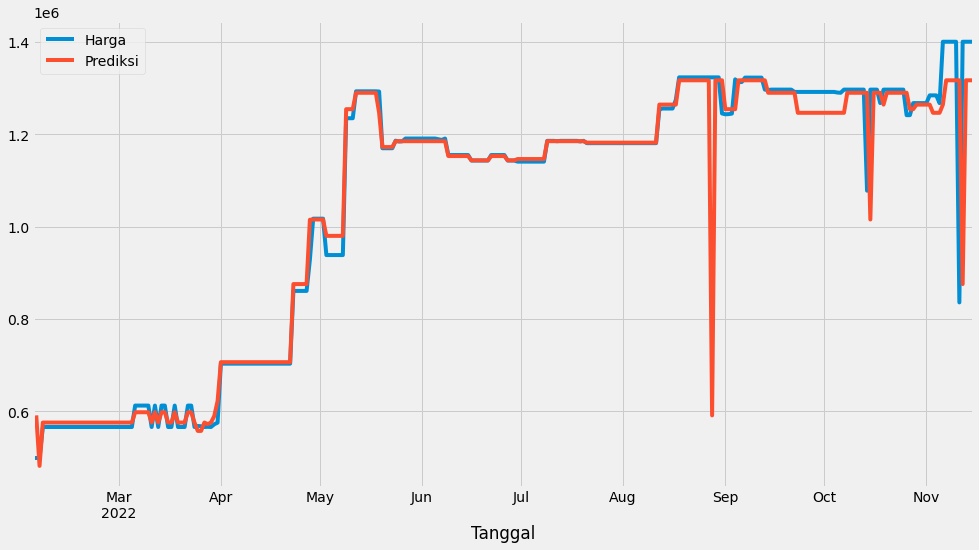

In [47]:
fig, ax = plt.subplots(figsize=(15,8))
df_cgk_dps2.plot(kind='line', ax=ax)
plt.show()

## Forecast

In [48]:
from datetime import timedelta, datetime
def forecast(data, nlags, days_until_depart):
  t = datetime(2022, 11, 15)
  time_list = [t]
  hasil_forecast=[1400688] #pokonya ini ambil data X_test indeksnya [-n_lags:], bebas lo ambilnya gimanss
  days_until_depart=44     #hari sblom brangkat, kalo lstm 1 hari sebelum berangkat

  for i in range(days_until_depart):
    forecast_={'lag':hasil_forecast}
    apaiya_df = pd.DataFrame(forecast_, index=time_list)
    fr=reg.predict(apaiya_df)
    list(fr)
    hasil_forecast.append(fr[i])
    time = t + timedelta(days=1)
    t = time
    time_list.append(time)
  return apaiya_df

In [49]:
apaiya_df=forecast(X_test, 1, 44)

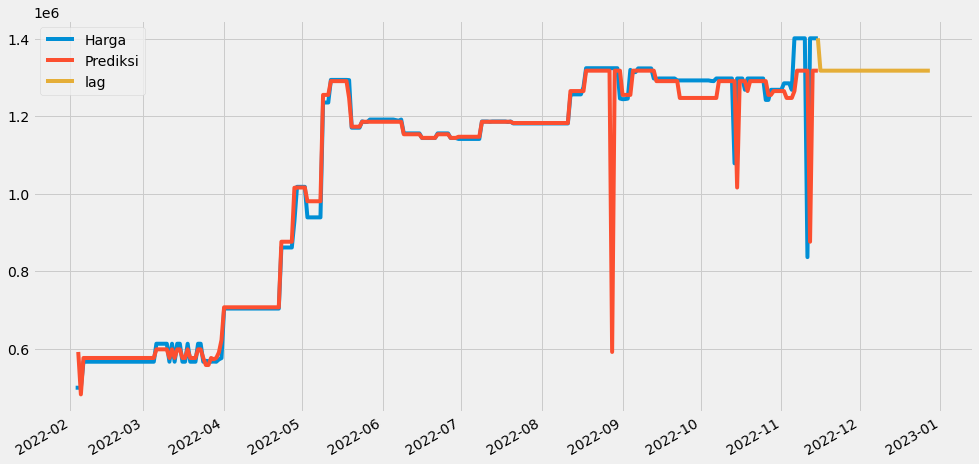

In [50]:
#Membuat plot 

from datetime import timedelta, datetime
df_cgk_dps3 = df_cgk_dps2.append(apaiya_df)
fig, ax = plt.subplots(figsize=(15,8))
df_cgk_dps3.plot(kind='line', ax=ax)
plt.show()

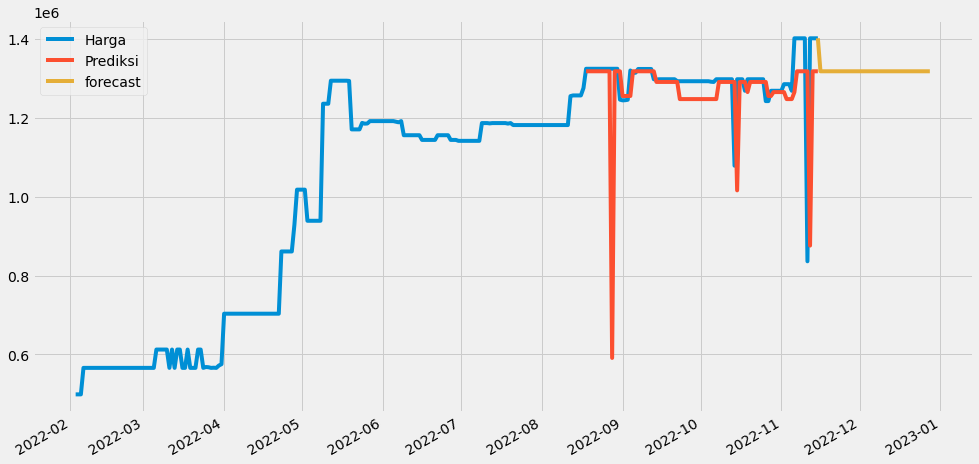

In [51]:
#Membuat plot 

from datetime import timedelta, datetime
df_cgk_dps4 = df_cgk_dps3
df_cgk_dps4. rename(columns = {'lag':'forecast'}, inplace = True)
df_cgk_dps4.iloc[1:-134, 1] = np.nan
fig, ax = plt.subplots(figsize=(15,8))
df_cgk_dps4.plot(kind='line', ax=ax)
plt.show()

# Koefisien Variansi

In [ ]:
df_cgk_dps.describe()

,Harga
count,2.860000e+02
mean,1.048434e+06
std,2.904519e+05
min,4.990000e+05
25%,7.033000e+05
50%,1.181001e+06
75%,1.292000e+06
max,1.400688e+06


In [ ]:
print('Koefisien Variansi CGK-DPS:',(np.sqrt(mean_squared_error(y_test,y_test_pred))/1.048434e+06)*100,'%')

Koefisien Variansi CGK-DPS: 12.088716814099062 %


In [ ]:
print(np.sqrt(mean_squared_error(y_test,y_test_pred)))

126742.21724273136
